In this notebook, we examine with the variances of the gradient estimators described in bernoulli_optimization_experiments.py

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import bernoulli_experiments_lib as bern_lib

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical

import itertools

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [3]:
np.random.seed(454)
_ = torch.manual_seed(454)

In [4]:
# fixed parameters
d = 3
# p0 = torch.rand(d)
p0 = torch.Tensor([0.6, 0.51, 0.48])
print('p0: ', p0, '\n')

print('sum(p0^2): ', torch.sum(p0**2))
print('sum((1 - p0)^2): ', torch.sum((1 - p0)**2), '\n')

# the optima
x_optimal = torch.argmin(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

optimal_loss = torch.min(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

print('optimal loss: ', optimal_loss)
print('optimal x: ', x_optimal.numpy())

p0:  tensor([ 0.6000,  0.5100,  0.4800]) 

sum(p0^2):  tensor(0.8505)
sum((1 - p0)^2):  tensor(0.6705) 

optimal loss:  tensor(0.6705)
optimal x:  1


In [5]:
# random init for phi
phi0 = torch.Tensor([0.0])
phi0.requires_grad_(True)
print('init phi0: ', phi0)
print('init e_b: ', sigmoid(phi0))

init phi0:  tensor([ 0.])
init e_b:  tensor([ 0.5000])


In [6]:
params = [phi0]
optimizer = optim.SGD(params, lr = 1.0)

# True gradient

In [7]:
bern_experiment = bern_lib.BernoulliExperiments(p0, d)

In [8]:
obj_class_reinforce = pm_lib.PartialMarginalizationREINFORCE(
                        f_z = bern_experiment.get_loss_from_draw_i,
                        var_params = deepcopy(phi0),
                        get_log_q_from_var_params = bern_experiment.get_bernoulli_log_prob_vec)

In [9]:
obj_class_reinforce.set_var_params(deepcopy(phi0))

In [10]:
optimizer.zero_grad()

In [11]:
loss = obj_class_reinforce.get_full_loss(diffble=True)

In [12]:
loss.backward()

In [13]:
true_grad = deepcopy(obj_class_reinforce.var_params.grad)
print(true_grad)

tensor(1.00000e-02 *
       [-4.5000])


In [14]:
# analytically integrate REINFORCE gradient: should recover the true gradient

In [15]:
obj_class_reinforce.set_var_params(deepcopy(phi0))
optimizer.zero_grad()
ps_loss = obj_class_reinforce.get_partial_marginal_loss(alpha = 0.0, topk = 8)

In [16]:
ps_loss.backward()
reinforce_analytic_grad = deepcopy(obj_class_reinforce.var_params.grad)
print(reinforce_analytic_grad)

tensor(1.00000e-02 *
       [-4.5000])


In [17]:
assert reinforce_analytic_grad == true_grad

In [18]:
# Function to sample the gradient from a given estimator 

def sample_gradient(phi0, obj_class_reinforce, topk, alpha, n_samples = 10000):
    params = [phi0]
    optimizer = optim.SGD(params, lr = 1.0)

    grad_array = torch.zeros(n_samples)
    
    for i in range(n_samples): 
        obj_class_reinforce.set_var_params(deepcopy(phi0))
        optimizer.zero_grad()
        ps_loss = obj_class_reinforce.get_partial_marginal_loss(alpha = alpha, topk = topk)
        ps_loss.backward()
        
        grad_array[i] = obj_class_reinforce.var_params.grad

        
    return grad_array

# Reinforce gradient

In [20]:
n_samples = 10000
reinforce_grads = sample_gradient(phi0, obj_class_reinforce, 
                                  topk = 0, 
                                  alpha = 0., 
                                  n_samples = n_samples)

In [21]:
print('true_grad: ', true_grad.numpy())
print('mean reinforce grad: ', torch.mean(reinforce_grads).numpy())
print('variance: ', torch.var(reinforce_grads).numpy())

print('scaled error: ', (torch.std(reinforce_grads) / np.sqrt(n_samples) * 3).numpy())

true_grad:  [-0.04500001]
mean reinforce grad:  -0.057431042
variance:  0.43400547
scaled error:  0.019763729


Text(0.5,0,'reinforce gradients')

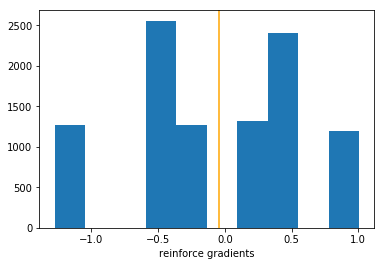

In [22]:
plt.hist(reinforce_grads)
plt.axvline(x=true_grad, color = 'orange') # true gradient 

plt.xlabel('reinforce gradients')

# Partial marginalization

In [24]:
print(phi0)

tensor([ 0.])


In [31]:
n_samples = 10000

mixed_grads_array = torch.zeros((2**d + 1, n_samples))

for i in range(0, 2**d + 1): 
    grads = sample_gradient(phi0, obj_class_reinforce, 
                                  topk = i, 
                                  alpha = 0., 
                                  n_samples = n_samples)
    
    mixed_grads_array[i, :] = grads
    
    print('topk = {}'.format(i))
    print('mean reinforce grad: ', torch.mean(grads).numpy())
    print('variance: ', torch.var(grads).numpy())


topk = 0
mean reinforce grad:  -0.045547545
variance:  0.43163463
topk = 1
mean reinforce grad:  -0.03286963
variance:  0.24368902
topk = 2
mean reinforce grad:  -0.052467234
variance:  0.20608073
topk = 3
mean reinforce grad:  -0.04680873
variance:  0.16318353
topk = 4
mean reinforce grad:  -0.040008154
variance:  0.12492949
topk = 5
mean reinforce grad:  -0.04510875
variance:  0.00036480842
topk = 6
mean reinforce grad:  -0.04493475
variance:  0.00012657091
topk = 7
mean reinforce grad:  -0.04500001
variance:  0.0
topk = 8
mean reinforce grad:  -0.04500001
variance:  0.0


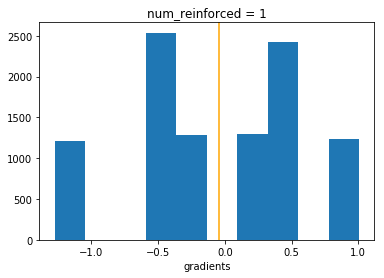

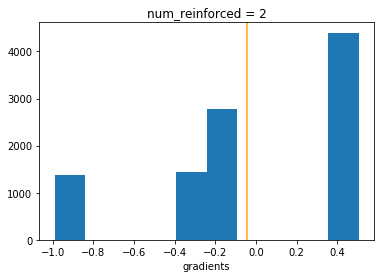

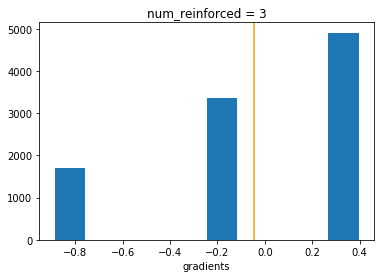

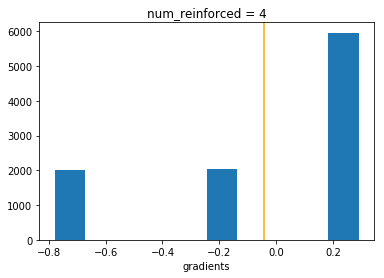

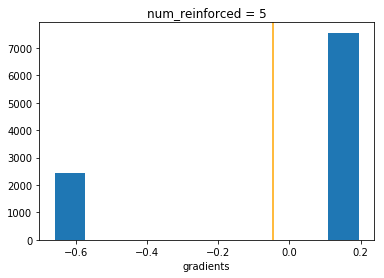

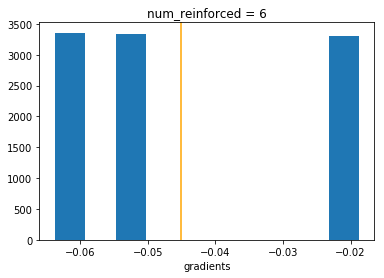

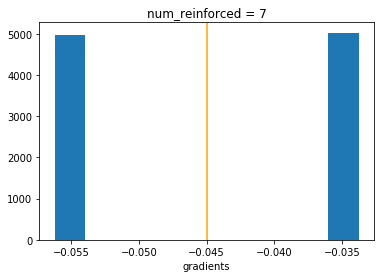

In [32]:
# Lets look at the histogram of the distribution of 
# the gradient estimates

for i in range(1, 2**d): 
    plt.figure()
    plt.hist(mixed_grads_array[i-1, :])
    plt.axvline(x=true_grad, color = 'orange') # true gradient 
    
    plt.title('num_reinforced = {}'.format(i))
    plt.xlabel('gradients')

Text(0.5,0,'num_reinforced')

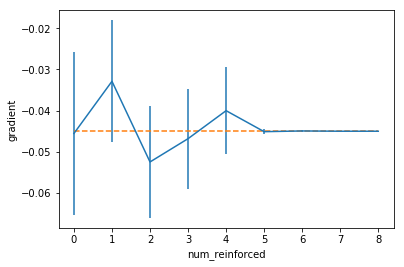

In [36]:
# summarize distribution all on the same plot
# Error bars are 3 * st. error of the distribution 

mixed_grads_means = np.mean(mixed_grads_array.numpy(), axis = 1)
mixed_grads_stds = np.std(mixed_grads_array.numpy(), axis = 1)

plt.errorbar(np.arange(0, 2**d + 1), 
             mixed_grads_means,
             yerr= mixed_grads_stds * 3 / np.sqrt(n_samples))

plt.plot(np.linspace(0, 2**d), true_grad.numpy() * np.ones(50), '--')

plt.ylabel('gradient')
plt.xlabel('num_reinforced')

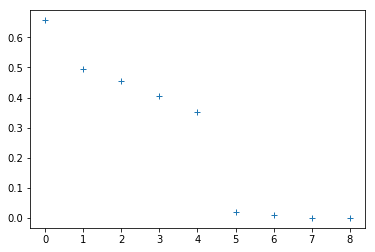

In [38]:
plt.plot(np.arange(0, 2**d + 1), mixed_grads_stds, '+')

In [34]:
# The effect of partial marginalization is better as the variational distribution becomes more concentrated

In [39]:
phi0 = torch.Tensor([3.0])
phi0.requires_grad_(True)

tensor([ 3.])

In [43]:
obj_class_reinforce.set_var_params(deepcopy(phi0))
_ = obj_class_reinforce.get_log_q()
print(obj_class_reinforce.class_weights)

tensor([ 0.0001,  0.0021,  0.0021,  0.0430,  0.0021,  0.0430,  0.0430,
         0.8644])


In [44]:
optimizer.zero_grad()
loss = obj_class_reinforce.get_full_loss(diffble=True)
loss.backward()


true_grad = deepcopy(obj_class_reinforce.var_params.grad)
print(true_grad)

tensor(1.00000e-03 *
       [-8.1318])


In [45]:
obj_class_reinforce.set_var_params(deepcopy(phi0))
optimizer.zero_grad()
ps_loss = obj_class_reinforce.get_partial_marginal_loss(alpha = 0.0, topk = 8)

ps_loss.backward()
reinforce_analytic_grad = deepcopy(obj_class_reinforce.var_params.grad)
print(reinforce_analytic_grad)

tensor(1.00000e-03 *
       [-8.1318])


In [46]:
assert reinforce_analytic_grad == true_grad

In [47]:
# re-examine the effect of partial marginalization

In [50]:
print(phi0)

tensor([ 3.])


In [51]:
n_samples = 10000

mixed_grads_array = torch.zeros((2**d + 1, n_samples))

for i in range(0, 2**d + 1): 
    grads = sample_gradient(phi0, obj_class_reinforce, 
                                  topk = i, 
                                  alpha = 0., 
                                  n_samples = n_samples)
    
    mixed_grads_array[i, :] = grads
    
    print('topk = {}'.format(i))
    print('mean reinforce grad: ', torch.mean(grads).numpy())
    print('variance: ', torch.var(grads).numpy())


topk = 0
mean reinforce grad:  -0.0049786186
variance:  0.07278688
topk = 1
mean reinforce grad:  -0.0077354326
variance:  0.0007697503
topk = 2
mean reinforce grad:  -0.008086975
variance:  0.0004976325
topk = 3
mean reinforce grad:  -0.008334441
variance:  0.0002703853
topk = 4
mean reinforce grad:  -0.008112884
variance:  2.1061885e-06
topk = 5
mean reinforce grad:  -0.008144005
variance:  1.0425847e-06
topk = 6
mean reinforce grad:  -0.008129552
variance:  1.7602937e-07
topk = 7
mean reinforce grad:  -0.008131799
variance:  0.0
topk = 8
mean reinforce grad:  -0.008131799
variance:  0.0


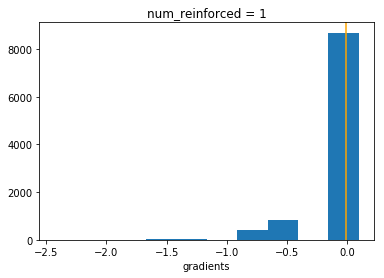

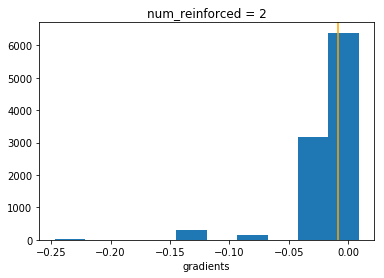

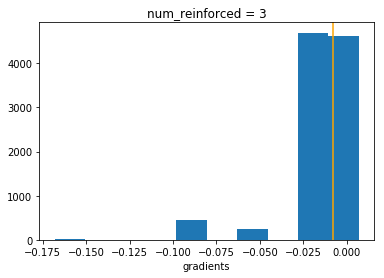

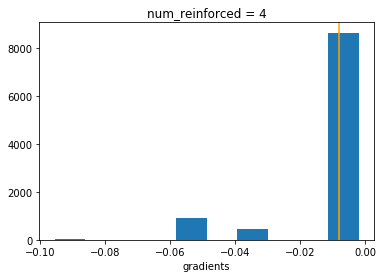

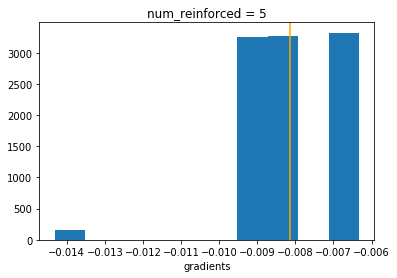

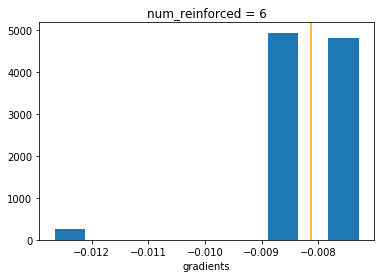

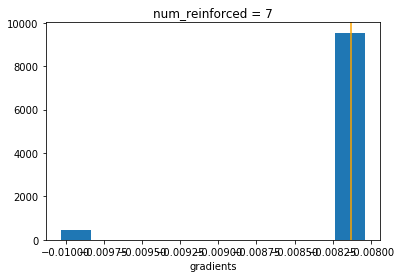

In [52]:
# Lets look at the histogram of the distribution of 
# the gradient estimates

for i in range(1, 2**d): 
    plt.figure()
    plt.hist(mixed_grads_array[i-1, :])
    plt.axvline(x=true_grad, color = 'orange') # true gradient 
    
    plt.title('num_reinforced = {}'.format(i))
    plt.xlabel('gradients')

Text(0.5,0,'number summed')

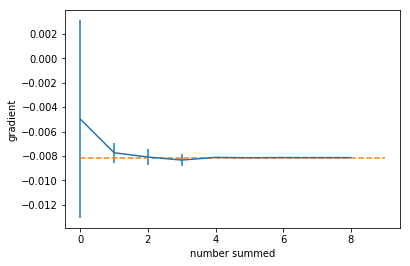

In [55]:
# summarize distribution all on the same plot
# Error bars are 3 * st. error of the distribution 

mixed_grads_means = np.mean(mixed_grads_array.numpy(), axis = 1)
mixed_grads_stds = np.std(mixed_grads_array.numpy(), axis = 1)

plt.errorbar(np.arange(0, 2**d + 1), 
             mixed_grads_means,
             yerr= mixed_grads_stds * 3 / np.sqrt(n_samples))

plt.plot(np.linspace(0, 2**d + 1), true_grad.numpy() * np.ones(50), '--')

plt.ylabel('gradient')
plt.xlabel('number summed')

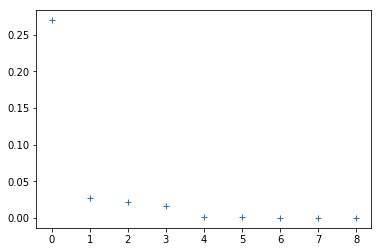

In [56]:
plt.plot(np.arange(0, 2**d + 1), mixed_grads_stds, '+')